In [ ]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'false'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

print("✅ Configurações de CPU aplicadas!")
print("⚠️ IMPORTANTE: Execute esta célula ANTES de importar o TensorFlow!")

✅ Configurações de CPU aplicadas!
⚠️ IMPORTANTE: Execute esta célula ANTES de importar o TensorFlow!


In [ ]:
import tensorflow as tf

tf.config.set_visible_devices([], 'GPU')

# Verifica se funcionou
print("=" * 60)
print("🔍 VERIFICAÇÃO DE DISPOSITIVOS")
print("=" * 60)
print("GPUs disponíveis:", tf.config.list_physical_devices('GPU'))
print("CPUs disponíveis:", tf.config.list_physical_devices('CPU'))

# Testa se realmente está usando CPU
with tf.device('/CPU:0'):
    a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
    b = tf.constant([[1.0, 1.0], [0.0, 1.0]])
    c = tf.matmul(a, b)
    print("✅ Teste de operação na CPU: SUCESSO!")
print("=" * 60)

🔍 VERIFICAÇÃO DE DISPOSITIVOS
GPUs disponíveis: []
CPUs disponíveis: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
✅ Teste de operação na CPU: SUCESSO!


E0000 00:00:1763338021.460540    8800 cuda_platform.cc:50] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # Para a Matriz de Confusão
import tensorflow.keras.utils as utils

from   tensorflow.keras.preprocessing.image import ImageDataGenerator
from   tensorflow.keras.models import Sequential
from   tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, ZeroPadding2D, Dropout
from   tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from   tensorflow.keras.utils import plot_model

# Imports para a Matriz de Confusão
from   sklearn.metrics import confusion_matrix, classification_report
from   pathlib import Path

warnings.filterwarnings("ignore")


Dispositivos Físicos GPU: []


In [ ]:

data_path = '/home/franciscobrilhante/Downloads/archive (1)/Garbage classification/Garbage classification' # Exemplo de caminho

main_folder_path = Path(data_path)
all_folders = [d for d in main_folder_path.glob('**/') if d.is_dir()]

# Contagem de arquivos por classe
data = []
for folder in all_folders:
    folder_name = folder.name
    file_count = len(list(folder.glob('*.*')))
    if folder_name != main_folder_path.name: 
        data.append({'Folder Name': folder_name, 'File Count': file_count})

count = pd.DataFrame(data)
count = count.set_index('Folder Name')

print("Contagem de imagens por classe:")
print(count)
print(f'\nTotal de imagens: {count.sum().values[0]}')

Contagem de imagens por classe:
             File Count
Folder Name            
cardboard           403
glass               501
metal               410
paper               594
plastic             482
trash               137

Total de imagens: 2527


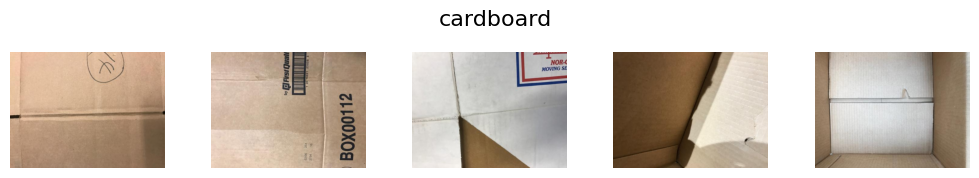

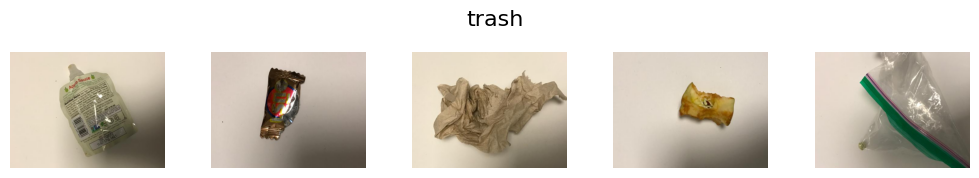

In [ ]:

def plot_imgs(item_dir, top=5):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:top]

    plt.figure(figsize=(10, 2)) # Ajustei o tamanho
    for idx, img_path in enumerate(item_files):
        plt.subplot(1, top, idx+1) # Ajustei para 1 linha
        img = plt.imread(img_path)
        plt.tight_layout()
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.suptitle(os.path.basename(item_dir), y=1.05, fontsize=16) 
    plt.show()


plot_imgs(data_path+'/cardboard')
plot_imgs(data_path+'/trash')

In [ ]:
batch_size = 30
target_size = (180, 180) # Tamanho que a CNN espera
validation_split = 0.15 # 15% dos dados serão usados para validação

# Data Augmentation
# Este é o gerador de TREINO. Ele combate o overfitting criando
# novas imagens (rotacionadas, com zoom, etc.) a cada época.
# É a solução para o dataset ser pequeno.
train_img_generator = ImageDataGenerator(rescale=1./255, # Normaliza
                                         validation_split=validation_split,
                                         horizontal_flip=True,
                                         vertical_flip=True,
                                         zoom_range = 0.5,
                                         width_shift_range = 0.3,
                                         height_shift_range = 0.3,
                                         rotation_range=50,
                                         shear_range = 0.3,
                                         fill_mode='nearest'
                                        )

#  Gerador de Teste/Validação
# Apenas o 'rescale'. NUNCA aumentando
# os dados de validação. Para saber como o modelo
# se sai em dados "limpos".
test_data_img_generator = ImageDataGenerator(rescale=1./255,
                                             validation_split=validation_split
                                            )

In [16]:
# Carrega os dados de TREINO (85% dos dados, com augmentation)
train_data = train_img_generator.flow_from_directory(data_path,
                                                        subset="training",
                                                        seed=133,
                                                        target_size=target_size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        color_mode='rgb',
                                                       )

# Carrega os dados de VALIDAÇÃO (15% dos dados, sem augmentation)
test_data = test_data_img_generator.flow_from_directory(data_path,
                                                        subset="validation",
                                                        seed=133,
                                                        target_size=target_size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        color_mode='rgb',
                                                        shuffle=False 
                                                       )

# Guarda os nomes das classes para a Matriz de Confusão
class_names = list(train_data.class_indices.keys())
print("Classes encontradas:", class_names)

Found 2150 images belonging to 6 classes.
Found 377 images belonging to 6 classes.
Classes encontradas: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [ ]:
# Definição da Arquitetura da CNN 
# Esta célula é a "Definição do Modelo".
# Usamos o `Sequential()`, que nos permite empilhar camadas uma após a outra,
model = Sequential()

# A entrada (input_shape) deve bater com o tamanho das nossas imagens (180x180)
# e com 3 canais de cor (RGB).
model.add(ZeroPadding2D(padding=(1, 1), input_shape=(target_size[0], target_size[1], 3)))

# Bloco 1
# (Este é o 1º bloco de "Conv2D -> ReLU -> MaxPooling2D" pedido)
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Dropout(0.3)) # Dropout para combater overfitting
model.add(MaxPool2D((2, 2)))

# Bloco 2
# (Este é o 2º bloco. Aumentamos os filtros para 64 para aprender padrões mais complexos)
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Dropout(0.3))
model.add(MaxPool2D((2, 2)))

# Bloco 3
# (Este é o 3º bloco. Aumentamos para 128 filtros para padrões ainda mais complexos)
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Dropout(0.4))
model.add(MaxPool2D((2, 2)))

# Classificador (Flatten -> Dense)
# 1. Flatten: Transforma o mapa 2D de padrões em um vetor 1D longo (uma "lista").
model.add(Flatten()) 
# 2. Dense (128): Uma camada "normal" de neurônios que começa a classificar os padrões.
model.add(Dense(128, activation='relu'))
# 3. Dropout (0.5): Combate o overfitting de forma agressiva no classificador.
model.add(Dropout(0.5))
# 4. Dense (64): Uma segunda camada para refinar a classificação.
model.add(Dense(64, activation='relu'))

# Camada de Saída
# Esta é a camada final que dá a resposta.
# 6 neurônios (um para cada classe: paper, glass, etc.)
# 'softmax' (ativação que transforma a saída em uma distribuição de probabilidade,
# ou seja, "tenho 70% de certeza que é papel, 15% que é plástico...", etc.)
model.add(Dense(6, activation='softmax'))

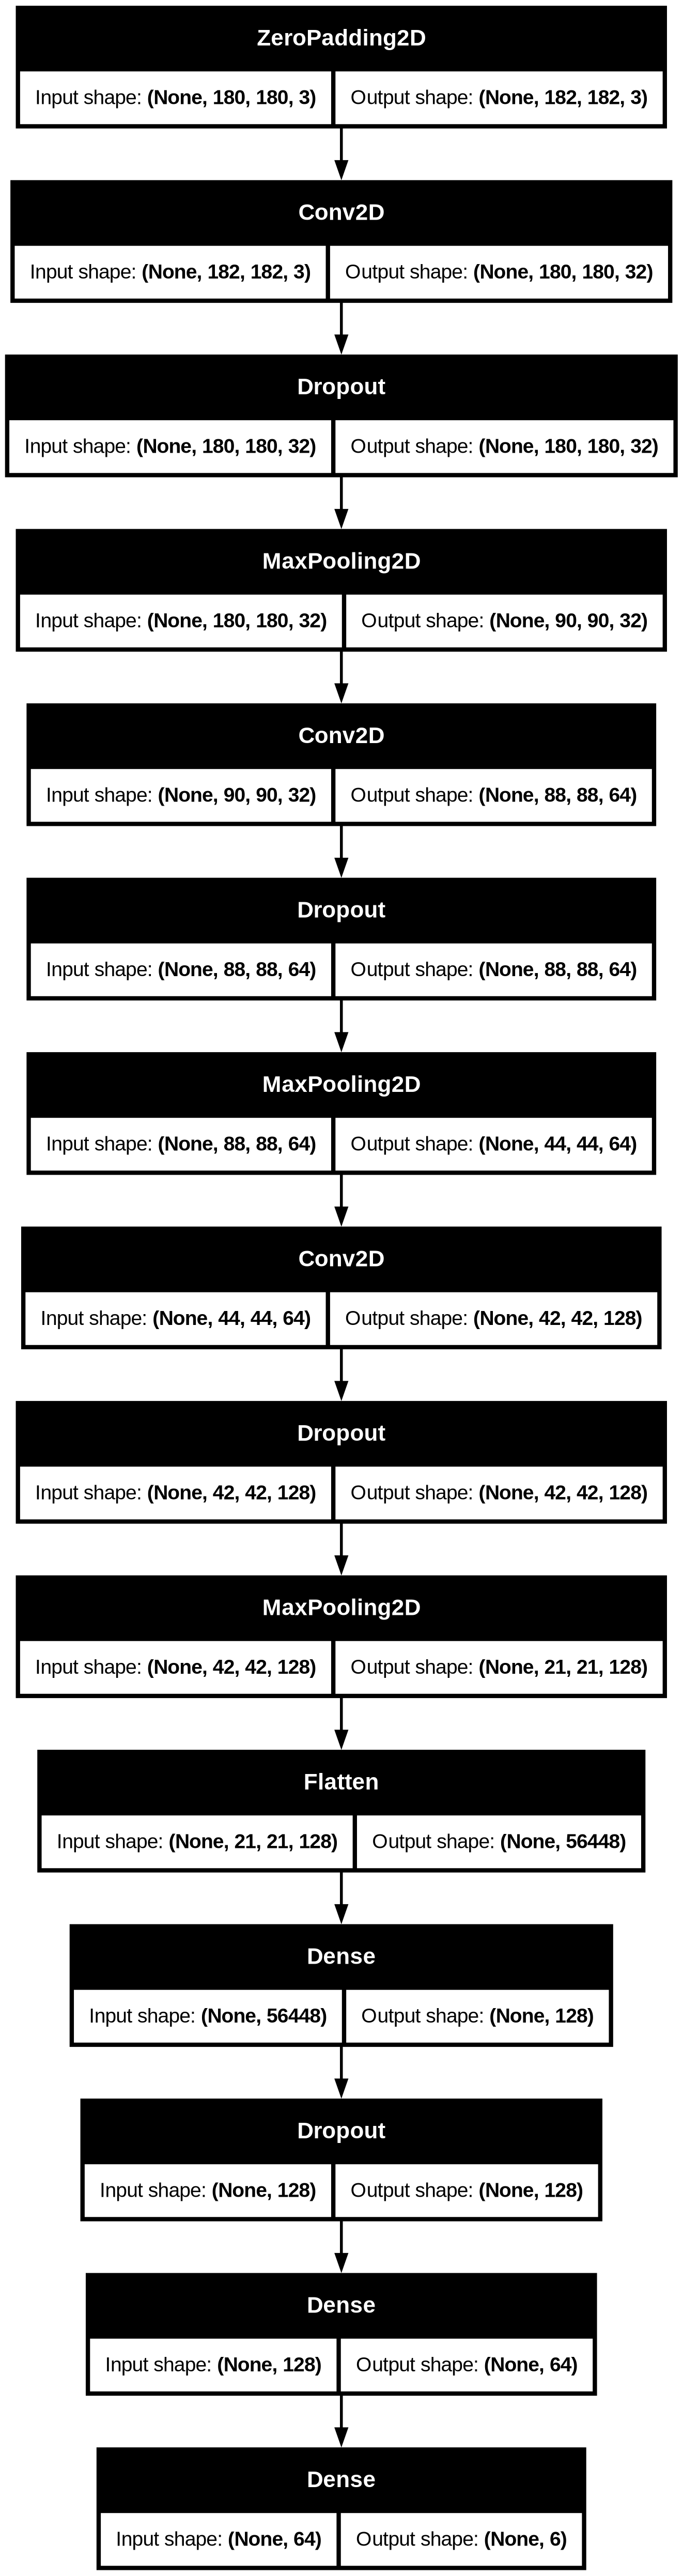

In [ ]:
# Callbacks 
# Para o treino se a 'val_loss' não melhorar.
ES = EarlyStopping(monitor='val_loss', mode='min', patience=10)
# Reduz a taxa de aprendizado se o treino estagnar.
RLROP = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.1, min_lr=0.01)
# Salva o *melhor* modelo (menor 'val_loss').
MCH = ModelCheckpoint('trash_best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

# Compila o modelo
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()]
             )

# Mostra um resumo da arquitetura
plot_model(model, show_shapes=True, show_layer_names=False)

In [ ]:
# Treinamento
history = model.fit(train_data,
                    steps_per_epoch=len(train_data),
                    epochs=500, 
                    validation_data=test_data,
                    validation_steps=len(test_data),
                    callbacks=[ES, RLROP, MCH]
                   )

best_score = max(history.history['val_categorical_accuracy'] )
print(f"Melhor pontuação de acurácia na validação: {best_score}")

Epoch 1/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - categorical_accuracy: 0.1888 - loss: 2.2176

72/72 ━━━━━━━━━━━━━━━━━━━━ 42s 563ms/step - categorical_accuracy: 0.2381 - loss: 1.8397 - val_categorical_accuracy: 0.2175 - val_loss: 1.7204 - learning_rate: 0.0010
Epoch 2/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - categorical_accuracy: 0.3013 - loss: 1.6198

72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 554ms/step - categorical_accuracy: 0.3172 - loss: 1.5982 - val_categorical_accuracy: 0.2891 - val_loss: 1.6621 - learning_rate: 0.0010
Epoch 3/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - categorical_accuracy: 0.3487 - loss: 1.5519

72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 553ms/step - categorical_accuracy: 0.3456 - loss: 1.5508 - val_categorical_accuracy: 0.2971 - val_loss: 1.6345 - learning_rate: 0.0010
Epoch 4/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - categorical_accuracy: 0.3714 - loss: 1.4948

72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 549ms/step - categorical_accuracy: 0.3633 - loss: 1.5115 - val_categorical_accuracy: 0.3263 - val_loss: 1.5681 - learning_rate: 0.0010
Epoch 5/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 547ms/step - categorical_accuracy: 0.3921 - loss: 1.4759 - val_categorical_accuracy: 0.3926 - val_loss: 1.6041 - learning_rate: 0.0010
Epoch 6/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - categorical_accuracy: 0.4071 - loss: 1.4685

72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 549ms/step - categorical_accuracy: 0.4372 - loss: 1.4167 - val_categorical_accuracy: 0.3634 - val_loss: 1.5101 - learning_rate: 0.0010
Epoch 7/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - categorical_accuracy: 0.4579 - loss: 1.3985

72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 552ms/step - categorical_accuracy: 0.4493 - loss: 1.4041 - val_categorical_accuracy: 0.3846 - val_loss: 1.4941 - learning_rate: 0.0010
Epoch 8/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 548ms/step - categorical_accuracy: 0.4484 - loss: 1.3868 - val_categorical_accuracy: 0.4058 - val_loss: 1.5495 - learning_rate: 0.0010
Epoch 9/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 548ms/step - categorical_accuracy: 0.4447 - loss: 1.4024 - val_categorical_accuracy: 0.3767 - val_loss: 1.5153 - learning_rate: 0.0010
Epoch 10/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 39s 545ms/step - categorical_accuracy: 0.4791 - loss: 1.3237 - val_categorical_accuracy: 0.3581 - val_loss: 1.5105 - learning_rate: 0.0010
Epoch 11/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 39s 545ms/step - categorical_accuracy: 0.4670 - loss: 1.3481 - val_categorical_accuracy: 0.3554 - val_loss: 1.5222 - learning_rate: 0.0010
Epoch 12/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 39s 545ms/step - categorical_accuracy: 0.4609 - loss: 1.3447 - val_categorical_a

72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 555ms/step - categorical_accuracy: 0.4879 - loss: 1.2919 - val_categorical_accuracy: 0.4005 - val_loss: 1.4768 - learning_rate: 0.0010
Epoch 15/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - categorical_accuracy: 0.5014 - loss: 1.2459

72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 550ms/step - categorical_accuracy: 0.4930 - loss: 1.2840 - val_categorical_accuracy: 0.4191 - val_loss: 1.4399 - learning_rate: 0.0010
Epoch 16/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 39s 546ms/step - categorical_accuracy: 0.4847 - loss: 1.2735 - val_categorical_accuracy: 0.4164 - val_loss: 1.4445 - learning_rate: 0.0010
Epoch 17/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - categorical_accuracy: 0.5208 - loss: 1.2213

72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 549ms/step - categorical_accuracy: 0.5172 - loss: 1.2257 - val_categorical_accuracy: 0.4403 - val_loss: 1.4139 - learning_rate: 0.0010
Epoch 18/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 39s 545ms/step - categorical_accuracy: 0.5144 - loss: 1.2392 - val_categorical_accuracy: 0.3926 - val_loss: 1.4404 - learning_rate: 0.0010
Epoch 19/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - categorical_accuracy: 0.5479 - loss: 1.1578

72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 550ms/step - categorical_accuracy: 0.5330 - loss: 1.1993 - val_categorical_accuracy: 0.4775 - val_loss: 1.4122 - learning_rate: 0.0010
Epoch 20/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 39s 548ms/step - categorical_accuracy: 0.5414 - loss: 1.1924 - val_categorical_accuracy: 0.4589 - val_loss: 1.4215 - learning_rate: 0.0010
Epoch 21/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - categorical_accuracy: 0.5386 - loss: 1.1949

72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 549ms/step - categorical_accuracy: 0.5577 - loss: 1.1680 - val_categorical_accuracy: 0.4695 - val_loss: 1.3894 - learning_rate: 0.0010
Epoch 22/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - categorical_accuracy: 0.5421 - loss: 1.1736

72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 550ms/step - categorical_accuracy: 0.5493 - loss: 1.1577 - val_categorical_accuracy: 0.5013 - val_loss: 1.3714 - learning_rate: 0.0010
Epoch 23/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 549ms/step - categorical_accuracy: 0.5386 - loss: 1.1759 - val_categorical_accuracy: 0.4430 - val_loss: 1.4034 - learning_rate: 0.0010
Epoch 24/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 39s 545ms/step - categorical_accuracy: 0.5702 - loss: 1.1455 - val_categorical_accuracy: 0.4721 - val_loss: 1.3756 - learning_rate: 0.0010
Epoch 25/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 39s 545ms/step - categorical_accuracy: 0.5772 - loss: 1.1189 - val_categorical_accuracy: 0.4350 - val_loss: 1.4604 - learning_rate: 0.0010
Epoch 26/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 39s 541ms/step - categorical_accuracy: 0.5651 - loss: 1.1380 - val_categorical_accuracy: 0.4721 - val_loss: 1.3834 - learning_rate: 0.0010
Epoch 27/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - categorical_accuracy: 0.5850 - loss: 1.0852

72/72 ━━━━━━━━━━━━━━━━━━━━ 39s 547ms/step - categorical_accuracy: 0.5842 - loss: 1.0942 - val_categorical_accuracy: 0.4562 - val_loss: 1.3614 - learning_rate: 0.0010
Epoch 28/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 39s 544ms/step - categorical_accuracy: 0.5916 - loss: 1.0844 - val_categorical_accuracy: 0.4934 - val_loss: 1.4395 - learning_rate: 0.0010
Epoch 29/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - categorical_accuracy: 0.5625 - loss: 1.0899

72/72 ━━━━━━━━━━━━━━━━━━━━ 39s 546ms/step - categorical_accuracy: 0.5674 - loss: 1.0923 - val_categorical_accuracy: 0.5172 - val_loss: 1.3251 - learning_rate: 0.0010
Epoch 30/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 39s 545ms/step - categorical_accuracy: 0.5814 - loss: 1.0921 - val_categorical_accuracy: 0.5119 - val_loss: 1.3591 - learning_rate: 0.0010
Epoch 31/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 548ms/step - categorical_accuracy: 0.5884 - loss: 1.0921 - val_categorical_accuracy: 0.5040 - val_loss: 1.3433 - learning_rate: 0.0010
Epoch 32/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 553ms/step - categorical_accuracy: 0.6037 - loss: 1.0379 - val_categorical_accuracy: 0.5146 - val_loss: 1.3772 - learning_rate: 0.0010
Epoch 33/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 39s 544ms/step - categorical_accuracy: 0.6116 - loss: 1.0494 - val_categorical_accuracy: 0.5252 - val_loss: 1.3686 - learning_rate: 0.0010
Epoch 34/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - categorical_accuracy: 0.6202 - loss: 1.0170

72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 550ms/step - categorical_accuracy: 0.6140 - loss: 1.0471 - val_categorical_accuracy: 0.5332 - val_loss: 1.3215 - learning_rate: 0.0010
Epoch 35/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - categorical_accuracy: 0.5596 - loss: 1.1321

72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 555ms/step - categorical_accuracy: 0.5888 - loss: 1.0714 - val_categorical_accuracy: 0.5438 - val_loss: 1.3095 - learning_rate: 0.0010
Epoch 36/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 39s 547ms/step - categorical_accuracy: 0.6028 - loss: 1.0625 - val_categorical_accuracy: 0.5332 - val_loss: 1.3254 - learning_rate: 0.0010
Epoch 37/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 39s 546ms/step - categorical_accuracy: 0.6312 - loss: 1.0137 - val_categorical_accuracy: 0.5252 - val_loss: 1.3789 - learning_rate: 0.0010
Epoch 38/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 39s 547ms/step - categorical_accuracy: 0.6074 - loss: 1.0294 - val_categorical_accuracy: 0.4801 - val_loss: 1.3382 - learning_rate: 0.0010
Epoch 39/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 39s 544ms/step - categorical_accuracy: 0.6428 - loss: 1.0051 - val_categorical_accuracy: 0.5411 - val_loss: 1.3127 - learning_rate: 0.0010
Epoch 40/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - categorical_accuracy: 0.6374 - loss: 0.9784

72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 560ms/step - categorical_accuracy: 0.6433 - loss: 0.9615 - val_categorical_accuracy: 0.5172 - val_loss: 1.3077 - learning_rate: 0.0010
Epoch 41/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - categorical_accuracy: 0.6465 - loss: 0.9665

72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 548ms/step - categorical_accuracy: 0.6409 - loss: 0.9678 - val_categorical_accuracy: 0.5756 - val_loss: 1.2821 - learning_rate: 0.0010
Epoch 42/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - categorical_accuracy: 0.6455 - loss: 0.9373

72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 557ms/step - categorical_accuracy: 0.6247 - loss: 0.9657 - val_categorical_accuracy: 0.5517 - val_loss: 1.2693 - learning_rate: 0.0010
Epoch 43/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 556ms/step - categorical_accuracy: 0.6479 - loss: 0.9605 - val_categorical_accuracy: 0.5279 - val_loss: 1.3299 - learning_rate: 0.0010
Epoch 44/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 547ms/step - categorical_accuracy: 0.6377 - loss: 0.9782 - val_categorical_accuracy: 0.5225 - val_loss: 1.3923 - learning_rate: 0.0010
Epoch 45/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 547ms/step - categorical_accuracy: 0.6107 - loss: 1.0253 - val_categorical_accuracy: 0.5093 - val_loss: 1.3530 - learning_rate: 0.0010
Epoch 46/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 39s 543ms/step - categorical_accuracy: 0.6367 - loss: 0.9788 - val_categorical_accuracy: 0.5066 - val_loss: 1.3720 - learning_rate: 0.0010
Epoch 47/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 39s 545ms/step - categorical_accuracy: 0.6544 - loss: 0.9193 - val_categorical

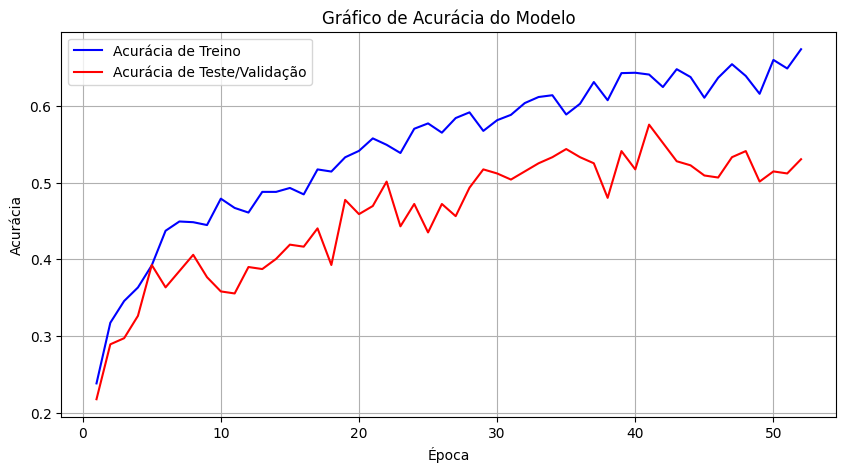

In [ ]:
# Gráfico de Acurácia
accuracy = history.history['categorical_accuracy']
val_accuracy = history.history['val_categorical_accuracy']
epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy, 'b', label='Acurácia de Treino')
plt.plot(epochs, val_accuracy, 'r', label='Acurácia de Teste/Validação')
plt.title('Gráfico de Acurácia do Modelo')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend();
plt.grid(True)
plt.show()

### Análise do Treinamento (Gráfico de Acurácia)

O gráfico acima é a prova visual de que o **overfitting** foi o principal desafio deste projeto. Este gráfico nos conta a história do aprendizado do modelo, época por época:

1.  **Linha Azul (Acurácia de Treino):** Representa o desempenho do modelo nos dados que ele *já viu* (os 2150 dados de treino). Ela subir de forma estável (chegando a ~67%) significa que o modelo está aprendendo com sucesso a "decorar" essas imagens. Ele está se tornando bom em acertar as respostas da prova que ele já tem.

2.  **Linha Vermelha (Acurácia de Teste/Validação):** Representa o desempenho do modelo em dados *novos*, que ele nunca viu (os 377 dados de validação). Esta linha é o verdadeiro teste de "inteligência" ou **generalização** do modelo.

#### Por que este é o Sinal Clássico de Overfitting?

O **"gap" (a abertura clara) entre as duas linhas é o sinal clássico do overfitting.**

Isso acontece porque o gráfico mostra o momento exato em que o modelo parou de *aprender* (a linha vermelha estagnou, parando na faixa dos ~57%) e passou apenas a *memorizar* (a linha azul continuou subindo).

* **A Inconstância (Linha "Espinhosa"):** Note como a linha vermelha (validação) é muito "espinhosa" e inconstante (sobe para 57%, cai para 51%, etc.). Isso indica que o modelo está *incerto*. Ele não está aprendendo padrões robustos; ele está apenas "tendo sorte" em alguns lotes de validação e "azar" em outros. Isso é típico de um dataset pequeno (como o utilizado), onde o *data augmentation* força o modelo a generalizar, mas ele não tem dados "limpos" suficientes para aprender os padrões com confiança.


In [21]:

model.load_weights('trash_best_model.h5')


test_data.reset()
Y_pred = model.predict(test_data, steps=len(test_data))
y_pred = np.argmax(Y_pred, axis=1)


y_true = test_data.classes

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


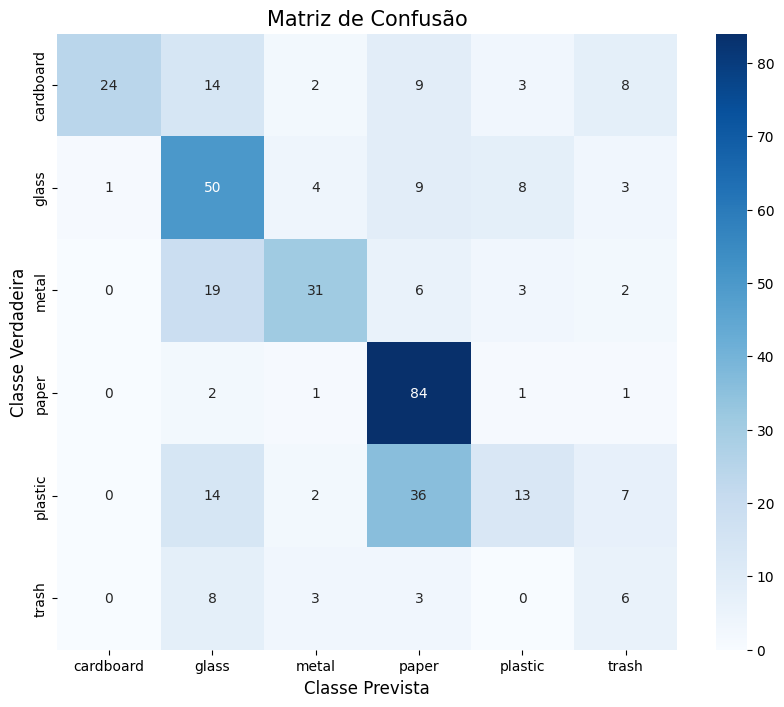

In [22]:
# Matriz de Confusão
# Eixo Y = Verdadeiro (O que era)
# Eixo X = Previsto (O que o modelo achou)
# A diagonal principal (cima-esquerda p/ baixo-direita) são os acertos.
# Fora da diagonal são os erros (ex: confundiu 'paper' com 'cardboard').

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Classe Prevista', fontsize=12)
plt.ylabel('Classe Verdadeira', fontsize=12)
plt.title('Matriz de Confusão', fontsize=15)
plt.show()

In [23]:


print("\n--- Relatório de Classificação ---")
print(classification_report(y_true, y_pred, target_names=class_names))


--- Relatório de Classificação ---
              precision    recall  f1-score   support

   cardboard       0.96      0.40      0.56        60
       glass       0.47      0.67      0.55        75
       metal       0.72      0.51      0.60        61
       paper       0.57      0.94      0.71        89
     plastic       0.46      0.18      0.26        72
       trash       0.22      0.30      0.26        20

    accuracy                           0.55       377
   macro avg       0.57      0.50      0.49       377
weighted avg       0.60      0.55      0.53       377



### Análise da Matriz de Confusão e Relatório de Classificação

O **Relatório de Classificação** acima nos dá as métricas frias (precisão, recall, F1-score) e confirma a acurácia total de **57.6%**.

A **Matriz de Confusão**, por sua vez, nos dá a história visual de *como* o modelo chegou a esse número.

#### Como Ler a Matriz de Confusão

* **Eixo Vertical (Y): "Classe Verdadeira"**
    Este eixo representa a realidade. Cada linha mostra o que a imagem *realmente* era (ex: a linha `plastic` contém todas as 72 imagens que eram, de fato, plástico).

* **Eixo Horizontal (X): "Classe Prevista"**
    Este eixo representa a *previsão* do modelo. Cada coluna mostra o que o modelo *achou* que a imagem era (ex: a coluna `paper` mostra tudo que o modelo rotulou como papel).

* **A Diagonal Principal (Acertos)**
    Os números na diagonal (do canto superior esquerdo ao inferior direito) são os **acertos**. É onde a "Classe Verdadeira" e a "Classe Prevista" são iguais (ex: o `84` na linha `paper` e coluna `paper`).

* **Fora da Diagonal (Erros)**
    Qualquer número fora da diagonal principal é um **erro** (uma confusão).

* **Os Tons de Azul (Intensidade)**
    A cor representa a contagem. Quadrados com **tons de azul mais escuros** indicam um número maior de imagens, facilitando a visualização rápida dos acertos e dos erros mais comuns.

#### Análise dos Nossos Resultados

Com isso, podemos ver claramente o porquê da acurácia de 57.6%:

* **✅ Pontos Fortes (Azul Escuro na Diagonal):**
    O modelo é **excelente** em identificar `paper` (acertou 84) e `metal` (acertou 31). O F1-score de 71% para `paper` confirma que esta foi a classe mais fácil de aprender.

* **❌ Pontos Fracos (Azul Escuro *Fora* da Diagonal):**
    O modelo é **péssimo** em identificar `plastic` (F1-score de 26%) e `trash` (F1 de 26%).

* **🔍 A Causa da Confusão (Onde o azul escuro aparece no lugar errado):**
    * **Plástico:** Olhando a linha `plastic`, vemos que o modelo acertou apenas **13**. O erro mais gritante é o quadrado `(plastic, paper)`, que mostra que o modelo classificou **36** imagens de plástico como `paper`. Ele também confundiu **14** imagens de plástico com `glass`.
    * **Trash:** Olhando a linha `trash`, o modelo acertou só **6**. Ele confundiu a maioria com `glass` (8 imagens) e `metal` (3 imagens).

Isso prova que o modelo sofreu com a alta similaridade visual (plástico vs. papel/vidro) e com o desbalanceamento de classes (poucas imagens de `trash`).

## 🎓 Conclusão Final do Projeto

### 1. O Impacto Real do Data Augmentation

Neste projeto, o **Data Augmentation** foi a nossa principal (e única) ferramenta contra o overfitting. Seu impacto foi de "dois gumes":

* **O Lado Positivo (Por que usar):** O *data augmentation* foi **crucial** para evitar um colapso total do modelo. Sem ele, o "gap" de overfitting (visto no gráfico do Bloco 10) teria sido muito mais rápido e severo. Ele forçou o modelo a generalizar: em vez de "decorar" a `paper1.jpg`, ele teve que aprender a reconhecer "papel" em diferentes ângulos, com zoom e invertido. Isso permitiu que ele aprendesse com sucesso as classes fáceis, como `paper` (F1-score de 71%).

* **O Lado Negativo (Suas Limitações):** O *data augmentation* **não cria informação nova**, ele apenas "remixa" a informação existente. Ele não conseguiu resolver nossos dois problemas principais:
    1.  **Desbalanceamento:** A classe `trash` tinha poucas imagens. Aumentar essas imagens apenas mostrou ao modelo as *mesmas 137 imagens* de lixo orgânico, mas em ângulos diferentes. Ele nunca aprendeu a variedade real do que "trash" pode ser.
    2.  **Similaridade Visual:** O modelo confundiu `plastic` com `paper` e `glass`. Nosso *data augmentation* (rotação, zoom) não ajudou o modelo a diferenciar um plástico transparente de um vidro transparente.

#### Quando usar (e quando *não* usar) Data Augmentation

* **Deve-se usar:** Quase **sempre** que se tem um dataset de imagens pequeno (< 50k imagens) e se observa overfitting. Ele é a primeira linha de defesa.
* **Não se deve usar (ou usar com cuidado):** Quando a transformação "quebra" o significado da imagem. Por exemplo, em imagens médicas, um `vertical_flip` (inversão vertical) pode tornar um raio-X inválido. Em um dataset de dígitos, inverter um "6" na horizontal o transforma em lixo, e invertê-lo na vertical o transforma em "9". Para o *nosso* projeto de lixo, virar uma garrafa de cabeça para baixo (`vertical_flip`) não muda o fato de ela ser vidro, por isso foi uma técnica válida.


### 2. O Resultado Final (57,6%) e o Papel dos Dados

A acurácia final de **57,6%** não é um "fracasso" do modelo; ela é a **prova** de que este dataset específico é um desafio significativo para uma arquitetura CNN simples.

O resultado é uma *diagnóstico* bem-sucedido que prova que, para este problema, a melhoria de desempenho não está na arquitetura da rede, mas sim nos **dados**.

* **O Exemplo Histórico (ImageNet):** O campo da Visão Computacional esteve estagnado por décadas. Modelos como **AlexNet** (2012) não revolucionaram a área porque sua arquitetura era magicamente diferente, mas porque foi o primeiro modelo a ser treinado no **ImageNet**, um dataset massivo de 1.4 milhões de imagens.
* **A Lição:** Uma arquitetura de CNN (como a nossa, ou a VGG, ou a ResNet) treinada com poucos dados (como o nosso TrashNet de 2.5k imagens) quase sempre falhará. A *mesma* arquitetura, quando exposta a milhões de imagens, torna-se capaz de aprender padrões complexos e generalizar.

Nosso resultado de 57,6% é, portanto, o teto esperado para esta arquitetura *dado este conjunto de dados*. A conclusão do trabalho é que a CNN funcionou, mas ela provou que a solução real para a classificação de lixo requer um dataset muito maior e mais balanceado.